In [125]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pandas as pd
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib import gridspec
from shapely.geometry import Point
import geopandas as gpd
from scipy.stats import f_oneway, chi2_contingency
pd.set_option('display.max_columns', None)

# Load dataset
data = pd.read_csv('OFFICIAL_cleaned_data_without_outliers.csv')

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13148 entries, 0 to 13147
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13148 non-null  object 
 1   Address        13148 non-null  object 
 2   Rooms          13148 non-null  int64  
 3   Type           13148 non-null  object 
 4   Price          13148 non-null  float64
 5   Method         13148 non-null  object 
 6   SellerG        13148 non-null  object 
 7   Date           13148 non-null  object 
 8   Distance       13148 non-null  float64
 9   Postcode       13148 non-null  float64
 10  Bedroom2       13148 non-null  float64
 11  Bathroom       13148 non-null  float64
 12  Car            13148 non-null  float64
 13  Landsize       13148 non-null  float64
 14  BuildingArea   13148 non-null  float64
 15  YearBuilt      13148 non-null  float64
 16  Lattitude      13148 non-null  float64
 17  Longtitude     13148 non-null  float64
 18  Region

Dataset

In [126]:
data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,120.054,2013.0,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.000,1900.0,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.000,1900.0,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,97.300,2009.0,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.000,2014.0,-37.8072,144.9941,Northern Metropolitan,4019.0


## Correlation Matrix

In [127]:
numeric_columns = ['Rooms', 'Price', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
                   'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']
categorical_columns = ['Type', 'Method', 'SellerG']

# Numeric vs Numeric Correlation
numeric_correlation = data[numeric_columns].corr()

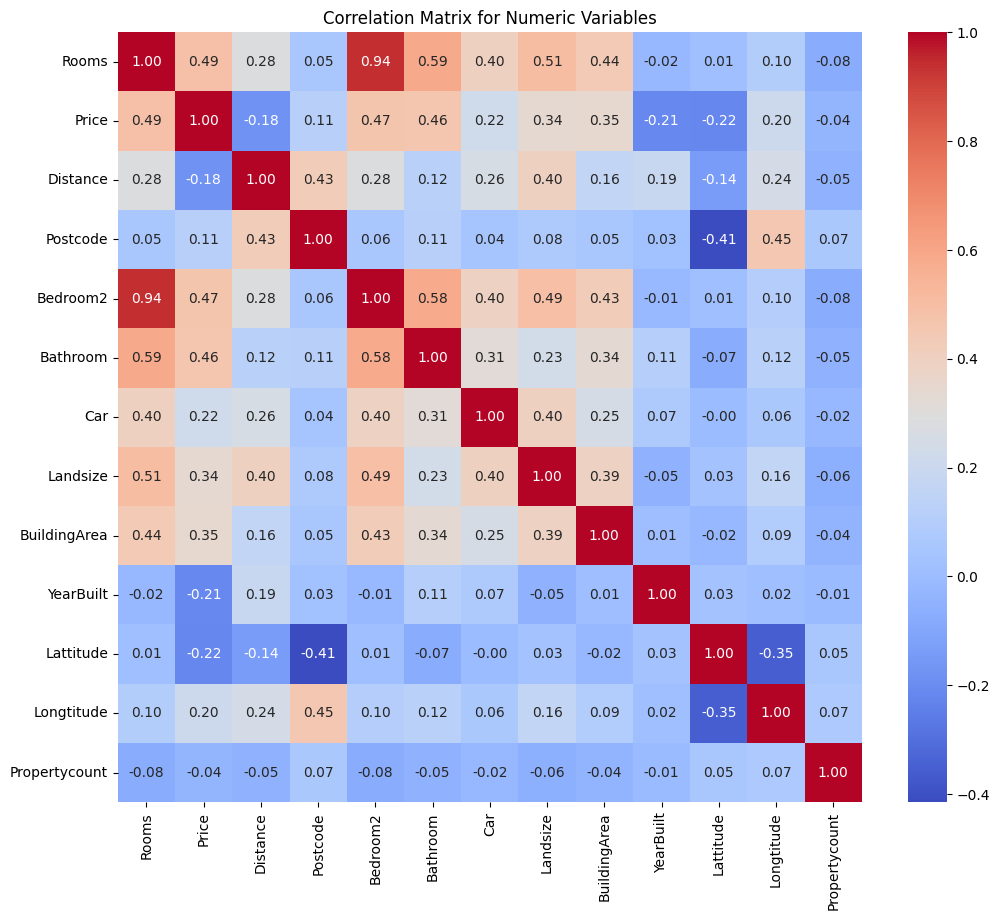

In [128]:
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_correlation, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix for Numeric Variables")
plt.show()

#### Highly correlated variables - **over the threshold of 0.6**

In [129]:
threshold = 0.5

high_correlation = (numeric_correlation.abs() >= threshold)

high_corr_pairs = [
    (var1, var2) for var1 in high_correlation.index for var2 in high_correlation.columns
    if high_correlation.loc[var1, var2] and var1 != var2
]


high_corr_pairs = set(tuple(sorted(pair)) for pair in high_corr_pairs)


high_corr_pairs_sorted = sorted(list(high_corr_pairs))
high_corr_pairs_sorted

[('Bathroom', 'Bedroom2'),
 ('Bathroom', 'Rooms'),
 ('Bedroom2', 'Rooms'),
 ('Landsize', 'Rooms')]

## Regional Price Analysis

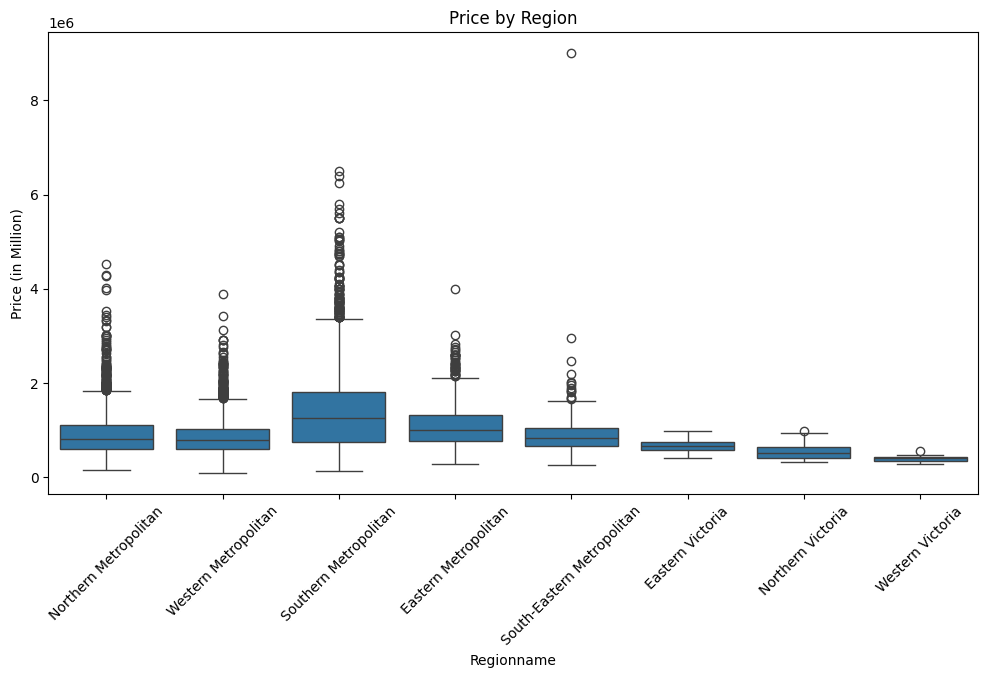

In [130]:
# Boxplots by Regions
plt.figure(figsize = (12, 6))
sns.boxplot(x = 'Regionname', y = 'Price', data = data)
plt.xticks(rotation = 45)
plt.title("Price by Region")
plt.ylabel('Price (in Million)')
plt.show()

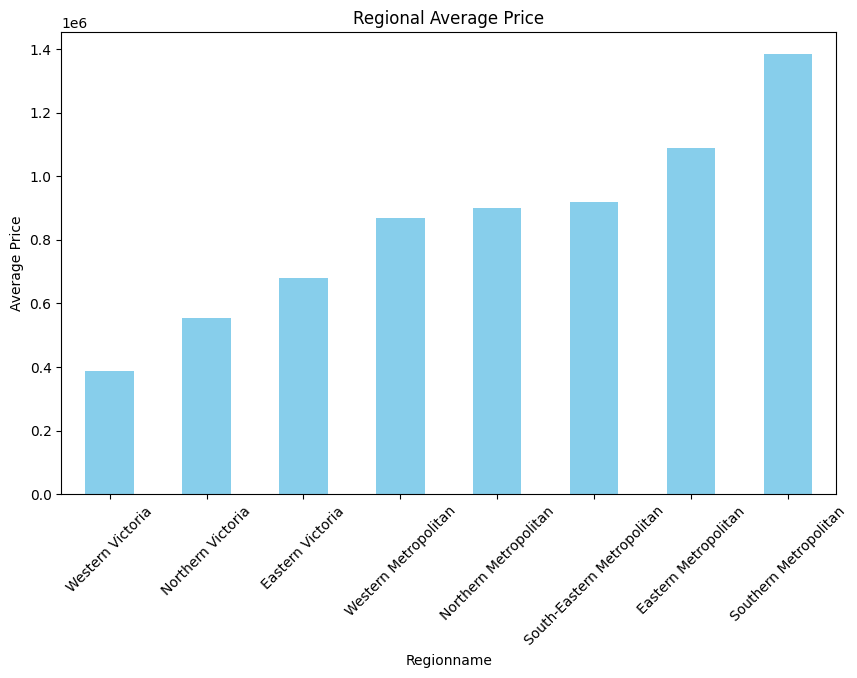

In [131]:
# Barplot of average price per region
# Group by region and calculate mean price per sqm
region_avg = data.groupby('Regionname')['Price'].mean().sort_values()

# Bar plot
plt.figure(figsize=(10, 6))
region_avg.plot(kind='bar', color='skyblue')
plt.ylabel("Average Price")
plt.title("Regional Average Price")
plt.xticks(rotation=45)
plt.show()

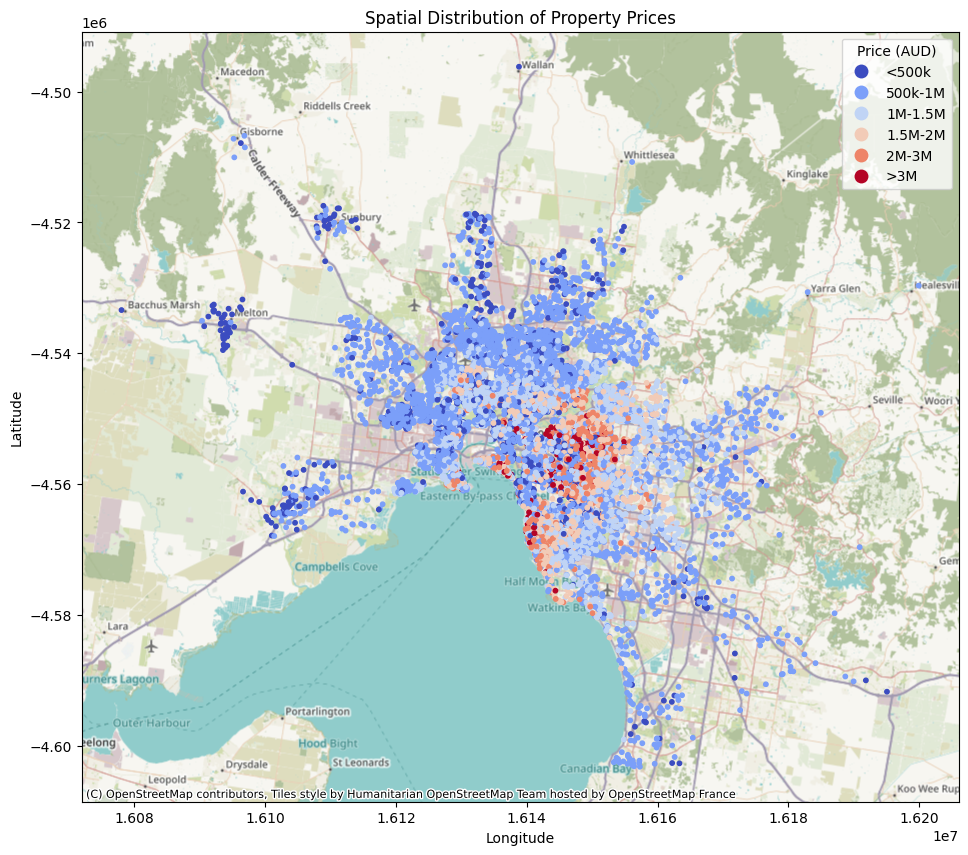

In [132]:
# Spatial Distribution of Property Prices
# Filter valid data for mapping
geo_data = data[['Lattitude', 'Longtitude', 'Price']]
gdf = gpd.GeoDataFrame(geo_data, geometry=gpd.points_from_xy(geo_data.Longtitude, geo_data.Lattitude))

# Ensure the GeoDataFrame has a CRS
gdf.set_crs(epsg=4326, inplace=True)  # Set CRS to WGS84
gdf = gdf.to_crs(epsg=3857)  # Reproject to Web Mercator (EPSG:3857)

# Categorize prices into ranges (bins)
price_bins = [0, 500000, 1000000, 1500000, 2000000, 3000000, gdf['Price'].max()]
price_labels = ['<500k', '500k-1M', '1M-1.5M', '1.5M-2M', '2M-3M', '>3M']
gdf['Price Range'] = pd.cut(gdf['Price'], bins=price_bins, labels=price_labels)

# Plot the map with categorized price ranges
fig, ax = plt.subplots(figsize=(12, 10))
gdf.plot(ax=ax, column='Price Range', legend=True, cmap='coolwarm', markersize=10, categorical=True)

# Add title to the legend
legend = ax.get_legend()
legend.set_title("Price (AUD)")

# Add basemap
ctx.add_basemap(ax, crs=gdf.crs)
plt.title("Spatial Distribution of Property Prices")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [133]:
# # Spatial Distribution of Property Prices ('Building_price_per_m2')
# # Filter valid data for mapping
# geo_data2 = data[['Lattitude', 'Longtitude', 'Land_price_per_m2']]
# gdf = gpd.GeoDataFrame(geo_data2, geometry=gpd.points_from_xy(geo_data2.Longtitude, geo_data2.Lattitude))

# # Ensure the GeoDataFrame has a CRS
# gdf.set_crs(epsg=4326, inplace=True)  # Set CRS to WGS84
# gdf = gdf.to_crs(epsg=3857)  # Reproject to Web Mercator (EPSG:3857)

# # Categorize prices into ranges (bins)
# price_bins = [0, 1000, 2000, 3000, 4000, 5000, gdf['Land_price_per_m2'].max()]
# price_labels = ['< 1k', '1k-2k','2k-3k', '3k-4k', '4k-5k', '>5k']
# gdf['Price Range'] = pd.cut(gdf['Land_price_per_m2'], bins=price_bins, labels=price_labels)

# # Plot the map with categorized price ranges
# fig, ax = plt.subplots(figsize=(12, 10))
# gdf.plot(ax=ax, column='Price Range', legend=True, cmap='coolwarm', markersize=10, categorical=True)

# # Add title to the legend
# legend = ax.get_legend()
# legend.set_title("Price per sqm (AUD)")

# # Add basemap
# ctx.add_basemap(ax, crs=gdf.crs)
# plt.title("Spatial Distribution of Property Prices per sqm")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.show()

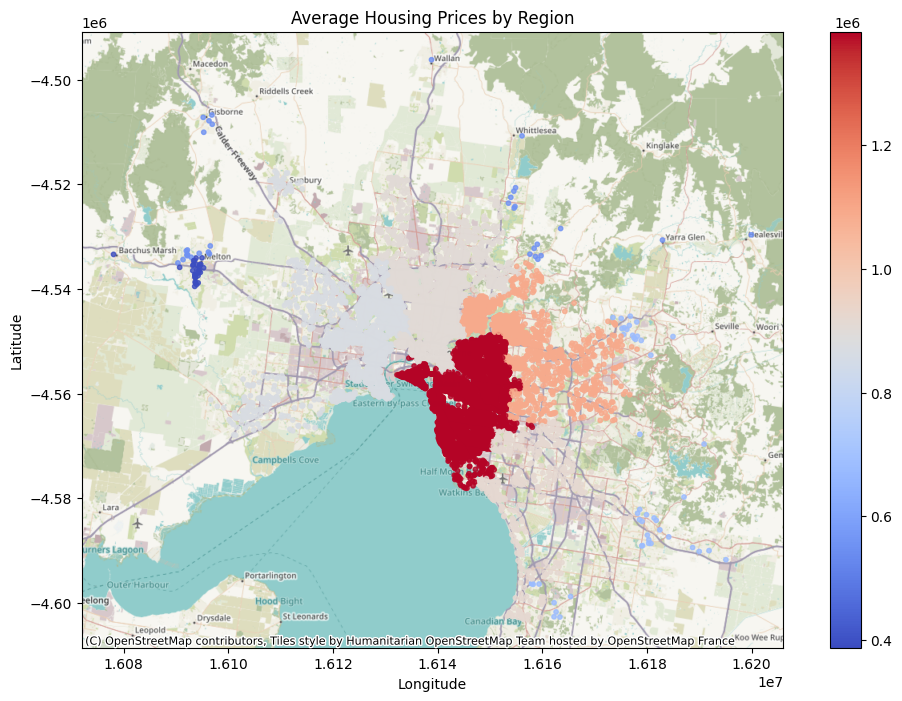

In [134]:
# Step 2: Data cleaning
# Drop rows with missing values in critical columns
filtered_data = data.dropna(subset=['Price', 'Lattitude', 'Longtitude', 'Regionname'])

# Step 3: Calculate the average price per region
average_price_per_region = filtered_data.groupby('Regionname')['Price'].mean().reset_index()

# Step 4: Merge the average prices back to include spatial data
region_geo = filtered_data[['Regionname', 'Lattitude', 'Longtitude']].drop_duplicates()
merged_data = region_geo.merge(average_price_per_region, on='Regionname')

# Step 5: Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    merged_data,
    geometry=gpd.points_from_xy(merged_data['Longtitude'], merged_data['Lattitude']),
    crs="EPSG:4326")  # WGS 84 Coordinate Reference System


# Ensure the GeoDataFrame has a CRS
gdf.set_crs(epsg=4326, inplace=True)  # Set CRS to WGS84
gdf = gdf.to_crs(epsg=3857)  # Reproject to Web Mercator (EPSG:3857)

# Step 7: Plot the data on a basemap
fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(ax=ax, column='Price', cmap='coolwarm', legend=True, markersize=10, alpha=0.8)

# Add basemap
ctx.add_basemap(ax, crs=gdf.crs)
plt.title("Average Housing Prices by Region")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [135]:
# Filter properties that are closest to the CBD (e.g., within 1 km)
cbd_properties = data[data['Distance'] <= 1]

# Calculate the average latitude and longitude of these properties
cbd_latitude = cbd_properties['Lattitude'].mean()
cbd_longitude = cbd_properties['Longtitude'].mean()

print(f"Latitude of CBD: {cbd_latitude}")
print(f"Longitude of CBD: {cbd_longitude}")

Latitude of CBD: -37.818399
Longitude of CBD: 144.963525


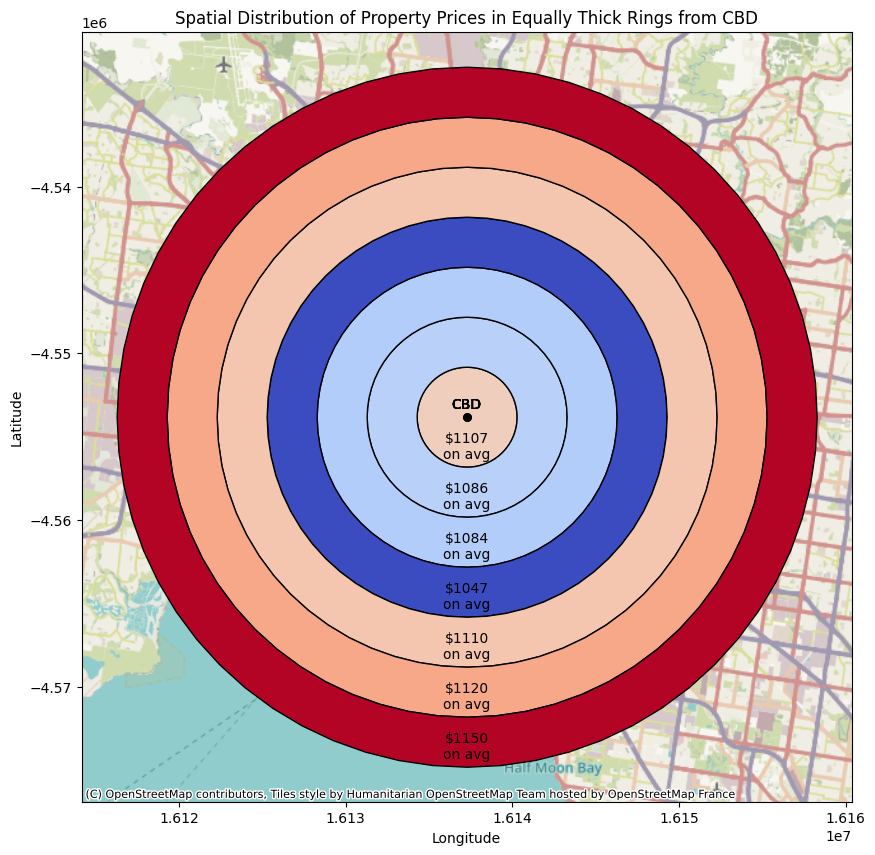

In [136]:
# Define the CBD point
cbd_point = Point(cbd_longitude, cbd_latitude)

# Define the distance intervals (in km) for equally thick rings
ring_thickness = 3  # Thickness of each ring in km
num_rings = 7  # Number of rings
distance_intervals = [ring_thickness * (i + 1) for i in range(num_rings)]

# Create a GeoDataFrame for the CBD point
cbd_gdf = gpd.GeoDataFrame([{'geometry': cbd_point}], crs="EPSG:4326")

# Reproject to a metric CRS (e.g., EPSG:3857) for distance calculations
cbd_gdf = cbd_gdf.to_crs(epsg=3857)
cbd_point_metric = cbd_gdf.geometry.iloc[0]

# Create rings around the CBD point
rings = []
for i, dist in enumerate(distance_intervals):
    if i == 0:
        inner_buffer = cbd_point_metric.buffer(0)  # Inner buffer is just the point itself
    else:
        inner_buffer = cbd_point_metric.buffer(distance_intervals[i-1] * 1000)  # Convert km to meters
    outer_buffer = cbd_point_metric.buffer(dist * 1000)  # Convert km to meters
    ring = outer_buffer.difference(inner_buffer)
    rings.append(ring)

# Create a GeoDataFrame for the rings
rings_gdf = gpd.GeoDataFrame(geometry=rings, crs="EPSG:3857")

# Reproject the property data to the same CRS
gdf = gdf.to_crs(epsg=3857)

# Calculate the average price within each ring
average_prices = []
for ring in rings:
    properties_in_ring = gdf[gdf.geometry.within(ring)]
    average_price = properties_in_ring['Price'].mean()
    average_prices.append(average_price)

# Create a color map based on the average prices
norm = plt.Normalize(vmin=min(average_prices), vmax=max(average_prices))
cmap = plt.cm.coolwarm

# Plot the rings with the corresponding colors
fig, ax = plt.subplots(figsize=(12, 10))
for ring, avg_price in zip(rings, average_prices):
    color = cmap(norm(avg_price))
    ring_gdf = gpd.GeoDataFrame(geometry=[ring], crs="EPSG:3857")
    ring_gdf.plot(ax=ax, edgecolor='black', facecolor=color, linewidth=1)
    # Get the centroid of the ring for labeling
    centroid = ring.centroid
    # Get the bounds of the ring for labeling
    minx, miny, maxx, maxy = ring.bounds
    label_x = (minx + maxx) / 2
    label_y = miny + 500  # Offset the label position slightly below the ring
    rounded_price = round(avg_price / 1000)  # Round to the nearest thousand
    ax.text(label_x, label_y, f"${rounded_price}\non avg", fontsize=10, ha='center', color='black')
    # Plot the CBD point
    cbd_gdf.plot(ax=ax, color='black', markersize=25, label='CBD')
    for x, y, label in zip(cbd_gdf.geometry.x, cbd_gdf.geometry.y, ['CBD']):
        ax.text(x, y + 500, label, fontsize=10, ha='center')  # Adjust y position slightly higher


# Add basemap
ctx.add_basemap(ax, crs=gdf.crs)

# Add title and labels
plt.title("Spatial Distribution of Property Prices in Equally Thick Rings from CBD")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Marginal relationship between Price and Rooms, Bathrooms, Landsize, and Distance from CBD (for RQ2) 

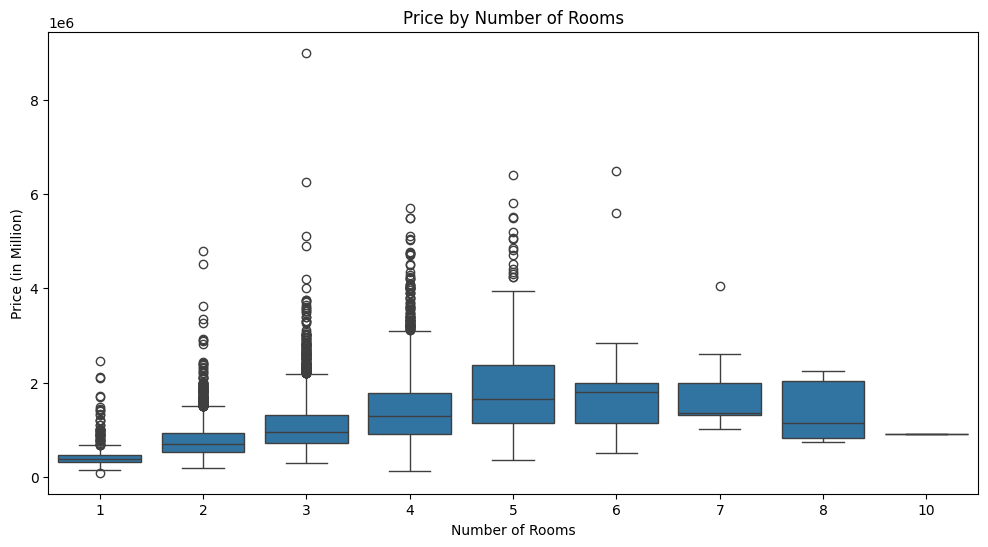

In [137]:
# Boxplots by Number of Rooms
plt.figure(figsize=(12, 6))
sns.boxplot(x='Rooms', y='Price', data=data)
plt.title("Price by Number of Rooms")
plt.xlabel('Number of Rooms')
plt.ylabel('Price (in Million)')
plt.show()

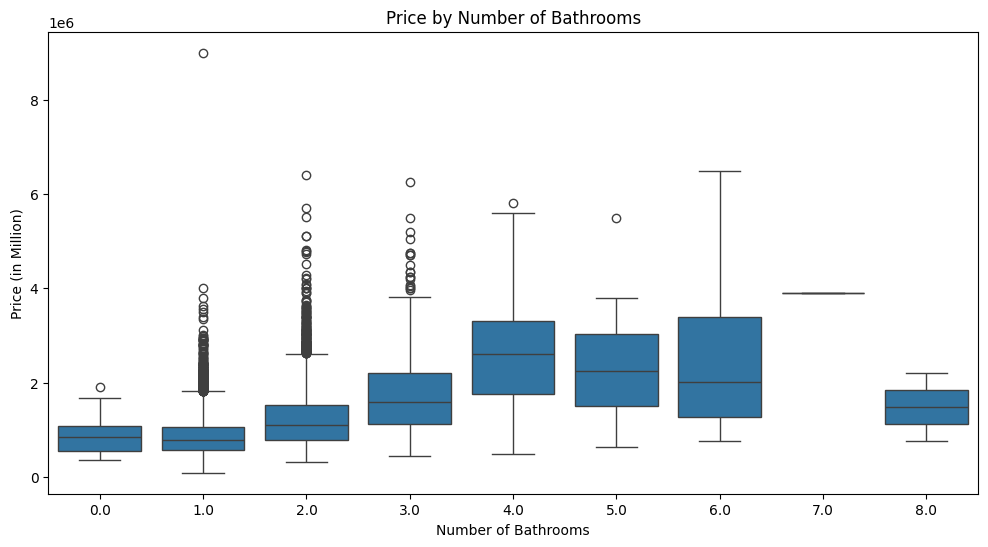

In [138]:
# Boxplots by Number of Bathrooms
plt.figure(figsize=(12, 6))
sns.boxplot(x='Bathroom', y='Price', data=data)
plt.title("Price by Number of Bathrooms")
plt.xlabel('Number of Bathrooms')
plt.ylabel('Price (in Million)')
plt.show()

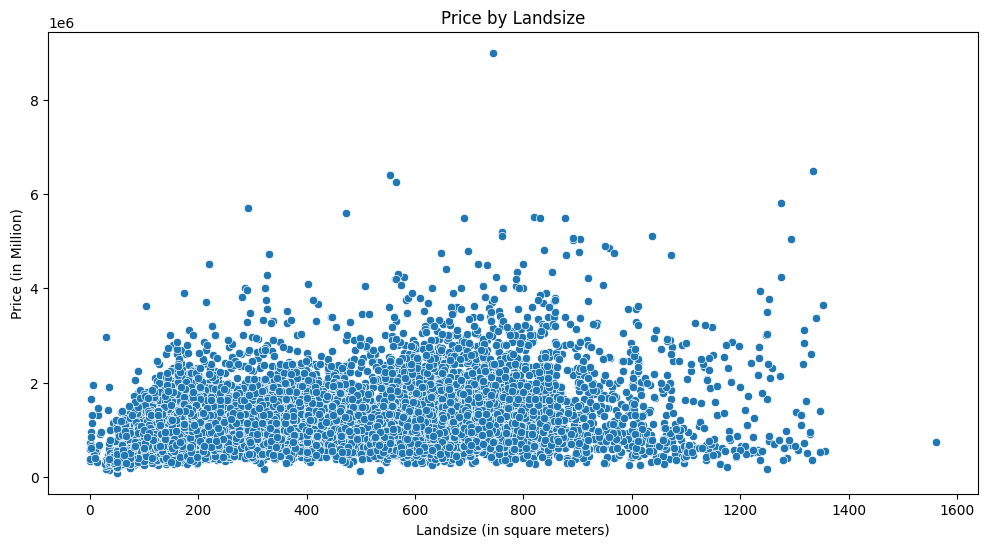

In [139]:
# Boxplot by Landsize
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Landsize', y='Price', data=data)
plt.title("Price by Landsize")
plt.xlabel('Landsize (in square meters)')
plt.ylabel('Price (in Million)')
plt.show()

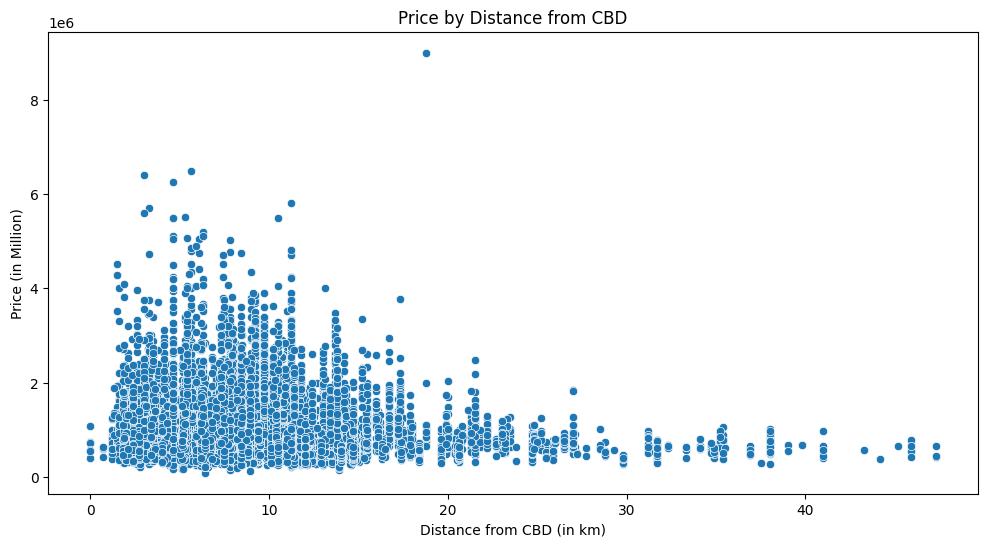

In [140]:
# Scatterplot Distance from CBD
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Distance', y='Price', data=data)
plt.title("Price by Distance from CBD")
plt.xlabel('Distance from CBD (in km)')
plt.ylabel('Price (in Million)')
plt.show()

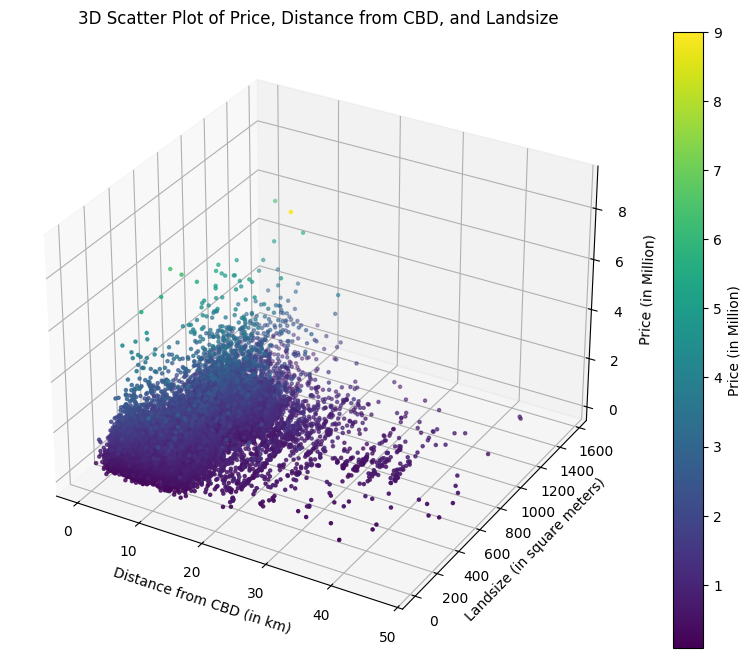

In [141]:
from mpl_toolkits.mplot3d import Axes3D

# Filter out rows with missing Landsize values
filtered_data = data.dropna(subset=['Landsize'])

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the data with even smaller points
sc = ax.scatter(filtered_data['Distance'], filtered_data['Landsize'], filtered_data['Price'] / 1e6, c=filtered_data['Price'] / 1e6, cmap='viridis', s=5)

# Add color bar
cbar = plt.colorbar(sc)
cbar.set_label('Price (in Million)')

# Set labels
ax.set_xlabel('Distance from CBD (in km)')
ax.set_ylabel('Landsize (in square meters)')
ax.set_zlabel('Price (in Million)')
ax.set_title('3D Scatter Plot of Price, Distance from CBD, and Landsize')

plt.show()